### Table of Contents
* [Introduction](#introduction)
* [Library Import](#library_import)
* [Data Import](#data_import)
* [Feature Selection](#feature_selection)
    * [Using the Human Mind](#using_the_human_mind)
    * [Using the Computer's Mind](#using_the_computers_mind)
* [Cross Validation & Train, Test, Split](#cross_validation)
    * [Human Performance](#human_performance)
    * [Computer Performance](#computer_performance)
* [Award Ceremony](#award_ceremony)

### Introduction<a class="anchor" id="introduction"></a>

The CMS data provides county and statewide medicare and medicaid information. There are a few target variables (*Actual Per Capita Cost*, *Average HCC Score*, etc.) to choose from. There are a variety of 'per capita' explanatory variables (*Ambulance Events Per 1000 Beneficiaries*, *Imaging Events Per 1000 Beneficiaries*, etc.) **Essentially, we want to see if a human can outperform a machine in predicting the *Actual Per Capita Cost* target variable.**

Here is the competition:
* The human is only allowed to use graphics to visually pick the 5 most important explanatory variables
* The computer is allowed to use penalized regression and decision trees to pick the 5 most important explanatory variables
* Two multiple linear regression models will be created
    * One with the 5 human chosen variables
    * One with the 5 computer chosen variables
* The species with the higher R^2 wins

### Library Import<a class="anchor" id="library_import"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.ensemble import RandomForestRegressor

### Data Import<a class="anchor" id="data_import"></a>
* Import excel spreadsheet and transform into pandas dataframe

In [2]:
# Create lists to help with data import
lst_sheets = ['State_county ' + str(i) for i in range(2007,2018+1)]
lst_df_name = ['df_' + str(i) for i in range(2007,2018+1)]
lst_yrs = [i for i in range(2007, 2018+1)]

# Read in master excel file
xls = pd.ExcelFile('./data/State County All Table 2018.xlsx')

# Create for loop to read in excel worksheet into yearly dataframes
for i in range(len(lst_df_name)):
    globals()[lst_df_name[i]] = pd.read_excel(xls, lst_sheets[i], skiprows=[0])
    lst_col = globals()[lst_df_name[i]].columns.to_list()
    lst_newcol = ['Year'].extend(lst_col)
    globals()[lst_df_name[i]]['Year'] = lst_yrs[i]

# Create list of dataframes to check if col names match and to concatenate
lst_df = [df_2007, df_2008, df_2009, df_2010, df_2011, df_2012, df_2013, df_2014, df_2015, df_2016, df_2017, df_2018]

# Check if col names match
for i in range(len(lst_df)-1):
    col_i = lst_df[i].columns.to_list()
    col_i_plus_1 = lst_df[i+1].columns.to_list()
    print(f'Do the {lst_yrs[i]} columns match the {lst_yrs[i+1]} columns? ',col_i == col_i_plus_1)

# Concatenate all dataframes
df = pd.concat(lst_df)
del lst_df, df_2007, df_2008, df_2009, df_2010, df_2011, df_2012, df_2013, df_2014, df_2015, df_2016, df_2017, df_2018

# Reorder columns so year is first column
lst_col_reorder = ['Year'] + df.columns.to_list()[:-1]
df = df[lst_col_reorder]

# Replace '*' and ' ' with NA
df = df.replace('*', np.NaN).replace(' ', np.NaN)

# Display sample of dataframe
df.sample(2)

Do the 2007 columns match the 2008 columns?  True
Do the 2008 columns match the 2009 columns?  True
Do the 2009 columns match the 2010 columns?  True
Do the 2010 columns match the 2011 columns?  True
Do the 2011 columns match the 2012 columns?  True
Do the 2012 columns match the 2013 columns?  True
Do the 2013 columns match the 2014 columns?  True
Do the 2014 columns match the 2015 columns?  True
Do the 2015 columns match the 2016 columns?  True
Do the 2016 columns match the 2017 columns?  True
Do the 2017 columns match the 2018 columns?  True


Year State   County  State and County FIPS Code  \
429   2011    GA  Carroll                     13045.0   
2599  2015    TN   Unicoi                     47171.0   

      Beneficiaries with Part A and Part B  FFS Beneficiaries  \
429                                16179.0            12023.0   
2599                                4875.0             2541.0   

      MA Beneficiaries MA Participation Rate  Average Age Percent Female  ...  \
429             4156.0               25.69 %         69.0        55.38 %  ...   
2599            2334.0               47.88 %         72.0        54.82 %  ...   

     PQI11 Bacterial Pneumonia Admission Rate (age < 65)  \
429                                                 NaN    
2599                                                NaN    

     PQI11 Bacterial Pneumonia Admission Rate (age 65-74)  \
429                                                 NaN     
2599                                                NaN     

     PQI11 Bacterial Pneumonia Admission Rate (age 75+)  \
429                                                 NaN   
2599                                                NaN   

     PQI12 UTI Admission Rate (age < 65) PQI12 UTI Admission Rate (age 65-74)  \
429                                  NaN                                  NaN   
2599                                 NaN                                  NaN   

     PQI12 UTI Admission Rate (age 75+)  \
429                                 NaN   
2599                                NaN   

      PQI15 Asthma in Younger Adults Admission Rate (age < 40)  \
429                                                 NaN          
2599                                                NaN          

      PQI16 Lower Extremity Amputation Admission Rate (age < 65)  \
429                                                 NaN            
2599                                                NaN            

      PQI16 Lower Extremity Amputation Admission Rate (age 65-74)  \
429                                                 NaN             
2599                                                NaN             

      PQI16 Lower Extremity Amputation Admission Rate (age 75+)  
429                                                 NaN          
2599                                                NaN          

[2 rows x 249 columns]

### Feature Selection<a class="anchor" id="feature_selection"></a>
* Choose which explanatory variables have the most predictive power

#### Using the Human Mind<a class="anchor" id="using_the_human_mind"></a>
* Again, the human is only allowed to use graphics to choose the top 5 explanatory variables

In [3]:
def state_plotter(y_axis_string, color_string, df=df):
    '''
    The overall purpose of the 'state_plotter' is to visualize a time series of a target variable against an explanatory variable 
    
    User defines the:
        - Y axis to be plotted
        - Column to visualize by
    And is returned:
        - Time series plot with each state as individual line
        - Colormap visualization using a particular column 
    '''
    # Create figure instance
    fig, ax = plt.subplots(figsize=(15,10))

    # Setup a colorbar for visualization
    df_temp = df.loc[df['County']=='STATE TOTAL']
    n=5 # Remove top and bottom 5 values from the colormap bar
    val_max = df_temp[color_string].nlargest(n).values.tolist()[n-1]
    val_min = df_temp[color_string].nsmallest(n).values.tolist()[n-1]
    normalize = mcolors.Normalize(vmin=val_min, vmax=val_max)
    colormap = cm.RdYlBu #rainbow, RdYlBu, viridis
    del df_temp

    # Create list of states to iterate through 
    lst_states = df['State'].unique().tolist()[1:-1]

    # Iterate through all states and plot y value over time
    for state in lst_states:
        # Define temporary dataframe with selected state and only state totals (i.e. not county totals)
        df_temp = df.loc[(df['State']==state) & (df['County']=='STATE TOTAL')]

        # Define x and y for plotting
        x = df_temp['Year']
        y = df_temp[y_axis_string]

        # Select median value for state for the color map
        val = np.median(df_temp[color_string].values)

        # Plot time series for one state
        plt.plot(x, y, color=colormap(normalize(val)), alpha=0.8)

    # Configure the colorbar
    scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
    scalarmappaple.set_array(df[color_string])
    cbar = plt.colorbar(scalarmappaple, orientation='horizontal', aspect=40)
    cbar.set_label(f'{color_string}', fontsize=14, labelpad=-60) #, rotation=270)


    # Add commas to y axis
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))

    # Configure plot
    plt.title(f'\"{y_axis_string}\" per State', fontsize=16) # + '\n Visualized by ' + f'\"{color_string}\"', fontsize=14)
    plt.ylabel(f'{y_axis_string} ($)', fontsize=14)
    plt.show()

* The following plots show the growth of per capita costs over time with color grades based on an explanatory variable
* The smoother the color gradation, the greater connection between per capita cost and the explatory variable

/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


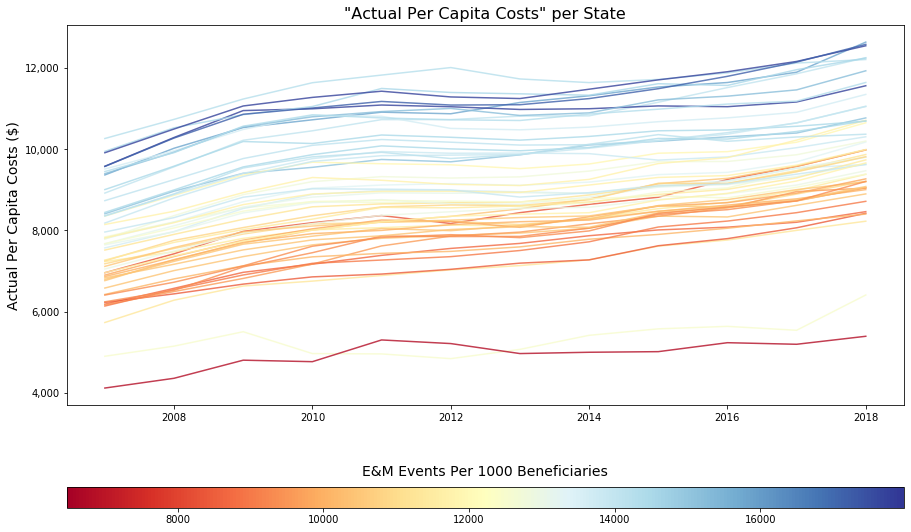

In [4]:
# An example of an explanatory variable with high predictive power
state_plotter(y_axis_string='Actual Per Capita Costs', color_string='E&M Events Per 1000 Beneficiaries', df=df)

/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


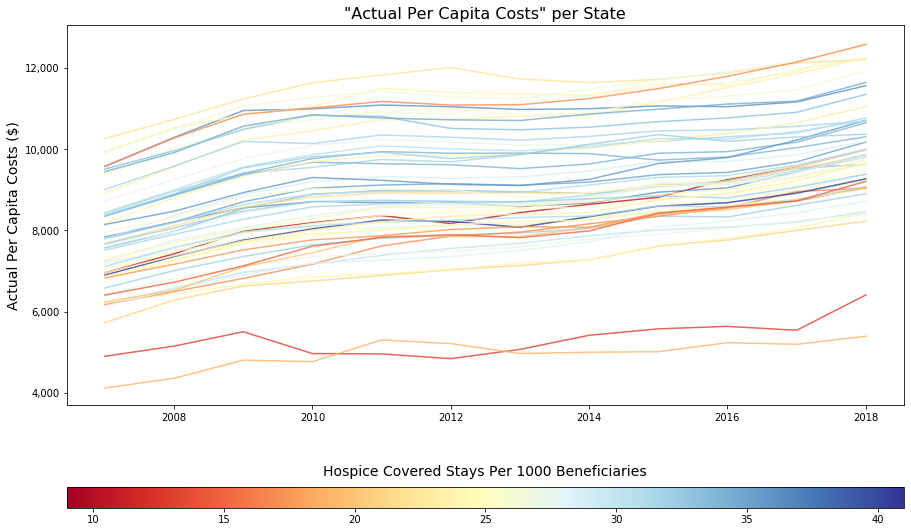

In [5]:
# An example of an explanatory variable with low predictive power
state_plotter(y_axis_string='Actual Per Capita Costs', color_string='Hospice Covered Stays Per 1000 Beneficiaries', df=df)

* The last human visualization... A correlation bar plot of all variables against per capita cost

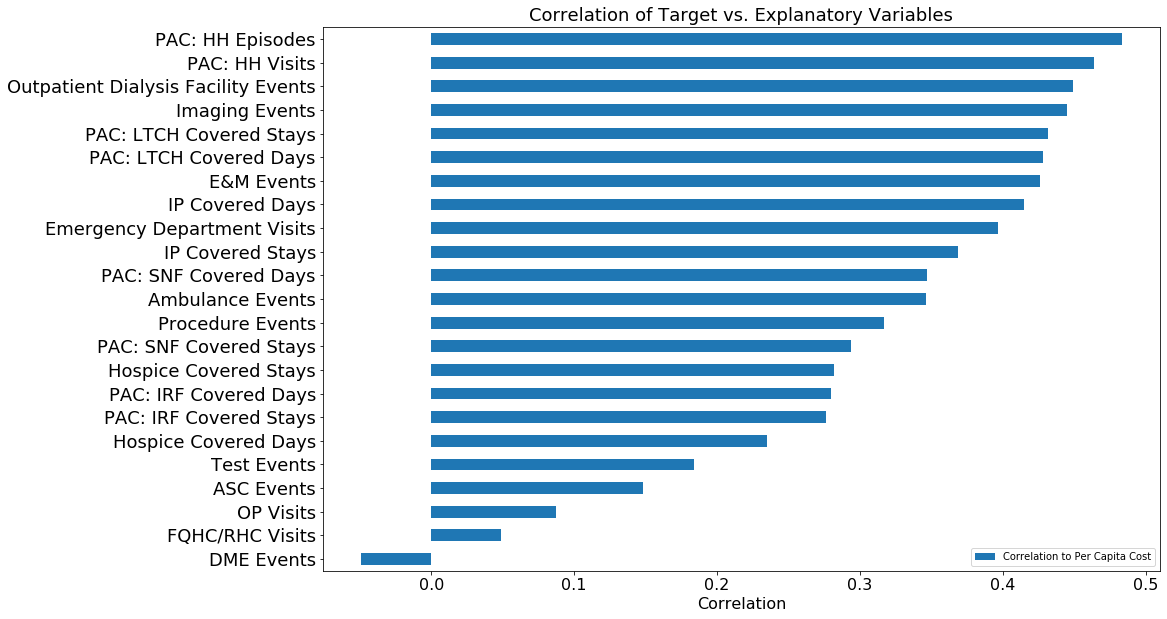

In [6]:
# Create list of all per capita columns
lst_per_cap = [s for s in lst_col if "1000 Beneficiaries" in s]

# Create correlation dataframe and transform into correct format for plotting
df_corr = df[['Actual Per Capita Costs'] + lst_per_cap].corr()['Actual Per Capita Costs'][:].reset_index().sort_values(by=['Actual Per Capita Costs'], ascending=False).rename(columns={"index": "Explanatory Variable", "Actual Per Capita Costs": "Correlation to Per Capita Cost"}, errors="raise").iloc[1:].sort_values(by=['Correlation to Per Capita Cost'], ascending=True)
df_corr['Explanatory Variable'] = df_corr['Explanatory Variable'].str.split(' Per', expand=True)[0]
df_corr['Explanatory Variable'] = df_corr['Explanatory Variable'].str.split(' per', expand=True)[0]
df_corr = df_corr.set_index('Explanatory Variable')

# Plot correlation bar chart
df_corr.plot.barh(sort_columns=False, figsize = (15, 10))

# Format Plot
plt.yticks(fontsize=18)
plt.xticks(fontsize=16)
plt.ylabel('')
plt.xlabel('Correlation', fontsize=16)
plt.title('Correlation of Target vs. Explanatory Variables', fontsize=18)
plt.show()

**Top 5 Variables According to Time Series Plot:**
* IP Covered Stays Per 1000 Beneficiaries
* PAC: SNF Covered Stays Per 1000 Beneficiaries
* E&M Events Per 1000 Beneficiaries
* *Imaging Events Per 1000 Beneficiaries*
* Emergency Department Visits per 1000 Beneficiaries

The full suite of time series plot can be found in [Appendix A](#appendix_a)

**Top 5 Variables According to Correlation Plot:**
* PAC: HH Episodes Per 1000 Beneficiaries
* PAC: HH Visits Per 1000 Beneficiaries
* Outpatient Dialysis Facility Events Per 1000 Beneficiaries
* *Imaging Events Per 1000 Beneficiaries*
* PAC: LTCH Covered Stays Per 1000 Beneficiaries

#### Using the Computer's Mind<a class="anchor" id="using_the_computers_mind"></a>
* Again, the computer is allowed to use any method to choose the top 5 explanatory variables
* We will examine the use of a ridge regression and random forest model

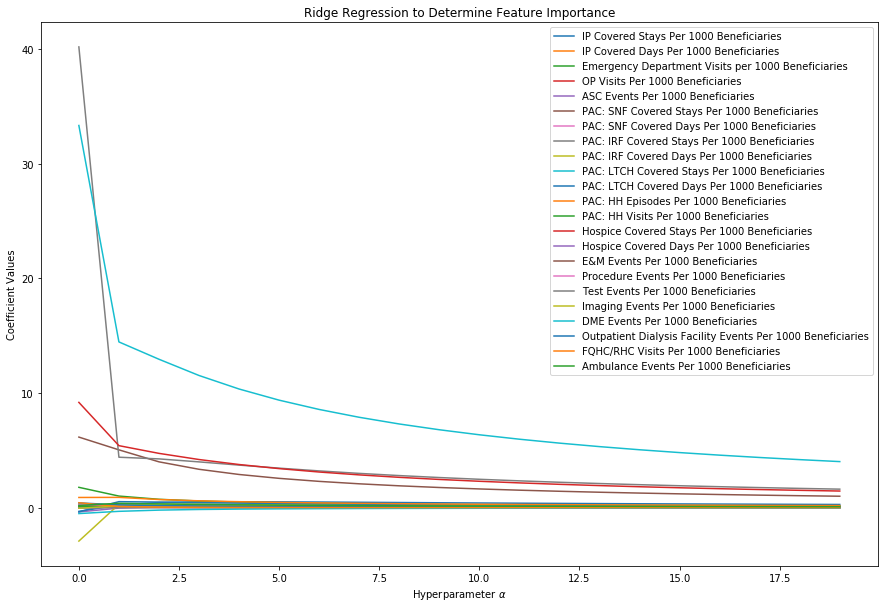

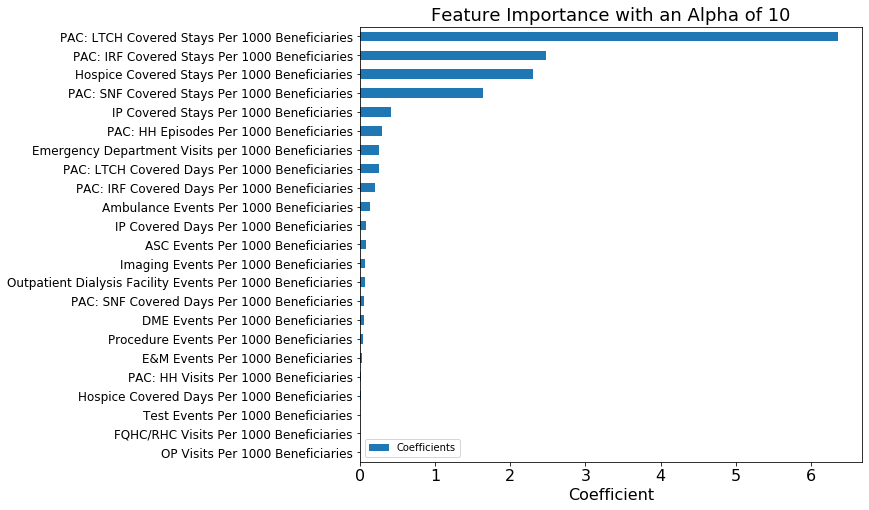

In [7]:
### Ridge Regression

# Columns of interest
lst_per_cap = [s for s in lst_col if "1000 Beneficiaries" in s]
lst_col = ['Year','State', 'Actual Per Capita Costs'] + lst_per_cap 

# Reduce df to just counties
df_county = df.loc[(df['County']!='STATE TOTAL') & (df['County']!='NATIONAL TOTAL')][lst_col]

# Drop NA's
df_county = df_county.dropna()

# Define X, y, and stratification
X = df_county[lst_per_cap]
y = df_county['Actual Per Capita Costs']

# Create model instance
ridge = Ridge()

# Make sure columns are normalized so that one feature does not appear more important than it is due to high values
ridge.set_params(normalize=True)

# Create empty coefficient list for each iteration of the alpha hyperparameter
coefs = []

# Create all alpha hyperparameters that you want to test
alphas = np.arange(0,20)

# Fit a model with a particular alpha and keep the coefficients stored
for alpha in alphas:
        ridge.set_params(alpha=alpha)
        ridge.fit(X, y)  
        coefs.append(ridge.coef_)
coefs = pd.DataFrame(coefs, index = alphas, columns = X.columns.to_list())  

# Plot results
plt.rcParams['figure.figsize'] = (15, 10)
for name in coefs.columns:
    plt.plot(coefs.index, coefs[name], label=name)
plt.title('Ridge Regression to Determine Feature Importance')
plt.xlabel(r'Hyperparameter $\alpha$')
plt.ylabel(r'Coefficient Values')
plt.legend()
plt.show()

def penalized_feature_importance_bar(coefs, alpha):
    
    # Create dataframe and find the coefficient values for a given alpha
    df = coefs.reset_index().rename(columns={"index": "Alpha"})
    df = df.iloc[(df['Alpha']-alpha).abs().argsort()[:1]].abs()
    df = df.loc[:, df.columns != 'Alpha']

    # Transform dataframe
    df = df.T
    df.columns = ['Coefficients']
    
    # Plot data
    df.sort_values('Coefficients', ascending=True).plot.barh(logy=False, sort_columns=True, figsize=(9, 8))
    plt.yticks(fontsize=12)
    plt.xticks(fontsize=16)
    plt.ylabel('')
    plt.xlabel('Coefficient', fontsize=16)
    plt.title('Feature Importance with an Alpha of ' + str(alpha), fontsize=18)
    plt.show()

#Plot coefficients using the function
penalized_feature_importance_bar(coefs, alpha=10)

In [8]:
### Random Forest

# Create model instance
rf = RandomForestRegressor()

# Fit model to training data
rf.fit(X, y)

# Define column names
names = X.columns.to_list()

# Print feature importance
print("Features sorted by their score:")
sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True)

Features sorted by their score:


[(0.3125, 'E&M Events Per 1000 Beneficiaries'),
 (0.1536, 'PAC: HH Episodes Per 1000 Beneficiaries'),
 (0.0944, 'Outpatient Dialysis Facility Events Per 1000 Beneficiaries'),
 (0.0509, 'Emergency Department Visits per 1000 Beneficiaries'),
 (0.0484, 'PAC: HH Visits Per 1000 Beneficiaries'),
 (0.0386, 'DME Events Per 1000 Beneficiaries'),
 (0.0359, 'Procedure Events Per 1000 Beneficiaries'),
 (0.0337, 'FQHC/RHC Visits Per 1000 Beneficiaries'),
 (0.026, 'PAC: SNF Covered Days Per 1000 Beneficiaries'),
 (0.0254, 'Ambulance Events Per 1000 Beneficiaries'),
 (0.024, 'OP Visits Per 1000 Beneficiaries'),
 (0.0166, 'PAC: LTCH Covered Days Per 1000 Beneficiaries'),
 (0.016, 'Hospice Covered Stays Per 1000 Beneficiaries'),
 (0.0156, 'PAC: LTCH Covered Stays Per 1000 Beneficiaries'),
 (0.0151, 'Imaging Events Per 1000 Beneficiaries'),
 (0.0148, 'ASC Events Per 1000 Beneficiaries'),
 (0.0139, 'PAC: SNF Covered Stays Per 1000 Beneficiaries'),
 (0.0135, 'Test Events Per 1000 Beneficiaries'),
 (0.012

**Top 5 Variables According to Ridge Regression:**
* PAC: LTCH Covered Stays Per 1000 Beneficiaries
* PAC: IRF Covered Stays Per 1000 Beneficiaries
* Hospice Covered Stays Per 1000 Beneficiaries
* PAC: SNF Covered Stays Per 1000 Beneficiaries
* IP Covered Stays Per 1000 Beneficiaries

**Top 5 Variables According to Random Forest:**
* E&M Events Per 1000 Beneficiaries
* PAC: HH Episodes Per 1000 Beneficiaries
* Outpatient Dialysis Facility Events Per 1000 Beneficiaries
* PAC: HH Visits Per 1000 Beneficiaries
* Emergency Department Visits per 1000 Beneficiaries

### Cross Validation & Train, Test, Split<a class="anchor" id="cross_validation"></a>

In [9]:
# Columns of interest
lst_per_cap = [s for s in lst_col if "1000 Beneficiaries" in s]
lst_col = ['Year','State', 'Actual Per Capita Costs'] + lst_per_cap 

# Reduce df to just counties
df_county = df.loc[(df['County']!='STATE TOTAL') & (df['County']!='NATIONAL TOTAL')][lst_col]

# Drop NA's
df_county = df_county.dropna()

# Define X, y, and stratification
X = df_county[lst_per_cap]
y = df_county['Actual Per Capita Costs']
strat = df_county['State']

# Create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=strat, random_state=42)

#### Human Performance<a class="anchor" id="human_performance"></a>

In [10]:
top_5_human_time_series = ['IP Covered Stays Per 1000 Beneficiaries','PAC: SNF Covered Stays Per 1000 Beneficiaries',
'E&M Events Per 1000 Beneficiaries','Imaging Events Per 1000 Beneficiaries',
'Emergency Department Visits per 1000 Beneficiaries']

top_5_human_correlation = ['PAC: HH Episodes Per 1000 Beneficiaries','PAC: HH Visits Per 1000 Beneficiaries',
'Outpatient Dialysis Facility Events Per 1000 Beneficiaries','Imaging Events Per 1000 Beneficiaries',
'PAC: LTCH Covered Stays Per 1000 Beneficiaries']

# Necessary imports: 
from sklearn.model_selection import cross_val_score

# Create model instance
lm = LinearRegression()

# Perform Cross-Validation and report results
scores = cross_val_score(lm, X_train[top_5_human_time_series], y_train, cv=6)
scores = [round(i,3) for i in scores]
print("Cross-validated R^2 scores on training data using time series plots:", scores)
print("Cross-validated R^2 score average on training data using time series plots:", round(sum(scores)/len(scores),3))
# Fit model and test on test data
lm.fit(X_train[top_5_human_time_series], y_train)
print('The R^2 score on testing data using time series plots:', round(lm.score(X_test[top_5_human_time_series], y_test), 3),'\n'*2)

# Perform Cross-Validation and report results
scores = cross_val_score(lm, X_train[top_5_human_correlation], y_train, cv=6)
scores = [round(i,3) for i in scores]
print("Cross-validated R^2 scores on training data using a correlation plot:", scores)
print("Cross-validated R^2 score average on training data using a correlation plot:", round(sum(scores)/len(scores),3))
# Fit model and test on test data
lm.fit(X_train[top_5_human_correlation], y_train)
print('The R^2 score on testing data using a correlation plot:', round(lm.score(X_test[top_5_human_correlation], y_test), 3))

Cross-validated R^2 scores on training data using time series plots: [0.407, 0.415, 0.457, 0.447, 0.432, 0.443]
Cross-validated R^2 score average on training data using time series plots: 0.434
The R^2 score on testing data using time series plots: 0.434 


Cross-validated R^2 scores on training data using a correlation plot: [0.449, 0.458, 0.44, 0.413, 0.462, 0.441]
Cross-validated R^2 score average on training data using a correlation plot: 0.444
The R^2 score on testing data using a correlation plot: 0.441


#### Computer Performance<a class="anchor" id="computer_performance"></a>

In [11]:
top_5_computer_ridge = ['PAC: LTCH Covered Stays Per 1000 Beneficiaries','PAC: IRF Covered Stays Per 1000 Beneficiaries',
'Hospice Covered Stays Per 1000 Beneficiaries','PAC: SNF Covered Stays Per 1000 Beneficiaries',
'IP Covered Stays Per 1000 Beneficiaries']

top_5_computer_forest = ['E&M Events Per 1000 Beneficiaries','PAC: HH Episodes Per 1000 Beneficiaries',
'Outpatient Dialysis Facility Events Per 1000 Beneficiaries','PAC: HH Visits Per 1000 Beneficiaries',
'Emergency Department Visits per 1000 Beneficiaries']
# Create model instance
lm = LinearRegression()


# Perform Cross-Validation and report results
scores = cross_val_score(lm, X_train[top_5_computer_ridge], y_train, cv=6)
scores = [round(i,3) for i in scores]
print("Cross-validated R^2 scores on training data using ridge regression:", scores)
print("Cross-validated R^2 score average on training data using ridge regression:", round(sum(scores)/len(scores),3))
# Fit model and test on test data
lm.fit(X_train[top_5_computer_ridge], y_train)
print('The R^2 score on testing data using ridge regression:', round(lm.score(X_test[top_5_computer_ridge], y_test), 3),'\n'*2)

# Perform Cross-Validation and report results
scores = cross_val_score(lm, X_train[top_5_computer_forest], y_train, cv=6)
scores = [round(i,3) for i in scores]
print("Cross-validated R^2 scores on training data using random forest:", scores)
print("Cross-validated R^2 score average on training data using random forest:", round(sum(scores)/len(scores),3))
# Fit model and test on test data
lm.fit(X_train[top_5_computer_forest], y_train)
print('The R^2 score on testing data using random forest:', round(lm.score(X_test[top_5_computer_forest], y_test), 3))

Cross-validated R^2 scores on training data using ridge regression: [0.284, 0.285, 0.294, 0.297, 0.286, 0.261]
Cross-validated R^2 score average on training data using ridge regression: 0.284
The R^2 score on testing data using ridge regression: 0.291 


Cross-validated R^2 scores on training data using random forest: [0.6, 0.591, 0.611, 0.591, 0.606, 0.603]
Cross-validated R^2 score average on training data using random forest: 0.6
The R^2 score on testing data using random forest: 0.61


#### Full Mutli-Linear Regression Performance<a class="anchor" id="computer_performance"></a>

In [12]:
# Create model instance
lm = LinearRegression()

# Perform Cross-Validation
scores = cross_val_score(lm, X_train, y_train, cv=6)
scores = [round(i,3) for i in scores]
print("Cross-validated R^2 scores on training data:", scores)
print("Cross-validated R^2 score average on training data:", round(sum(scores)/len(scores),3),'\n')

# Fit model and test on test data
lm.fit(X_train, y_train)
print('The R^2 score average on testing data:', round(lm.score(X_test, y_test), 3))

Cross-validated R^2 scores on training data: [0.749, 0.744, 0.754, 0.746, 0.755, 0.752]
Cross-validated R^2 score average on training data: 0.75 

The R^2 score average on testing data: 0.758


### Award Ceremony<a class="anchor" id="award_ceremony"></a>

Order of feature selection performance:
1. Computer - Random Forest (R^2 of 0.61)
2. Human - Correlation Plot (R^2 of 0.44)
3. Human - Time Series Plot (R^2 of 0.43)
4. Computer - Penalized Regression (R^2 of 0.29)

According to the rules of our competition **the Computer is the WINNER**.

In reality though, the strategy of just including more data is the real winner. When creating a muliple linear regression model will all per capita variables, it outcompeted the others (R^2 of 0.76). In this case, multicollinearity and model stability is not a concern. Including all variables generates a model with the highest predictive power. The conclusion is that, feature selection should be left to the computers and that oftentimes more data means more predictive power.

In [13]:
lst = ['Computer - Random Forest', 'Human - Correlation Plot', 'Human - Time Series Plot', 'Computer - Penalized Regression']
lst2 = [0.61, 0.44, 0.43, 0.29]
df_score = pd.DataFrame(list(zip(lst, lst2)), 
               columns =['Feature Selection Method', 'R^2']) 
df_score

Feature Selection Method   R^2
0         Computer - Random Forest  0.61
1         Human - Correlation Plot  0.44
2         Human - Time Series Plot  0.43
3  Computer - Penalized Regression  0.29

#### Appendix A<a class="anchor" id="appendix_a"></a>

/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


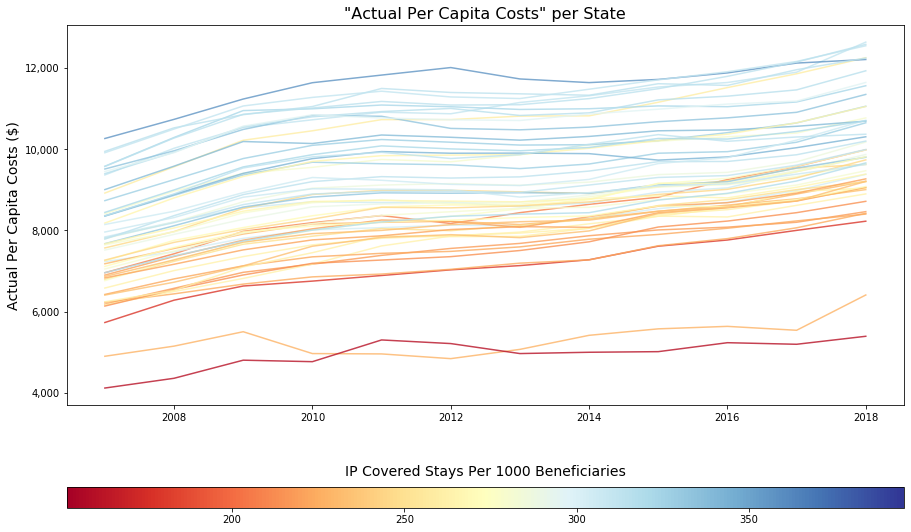

______________________________________________________________________________________________________________



/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


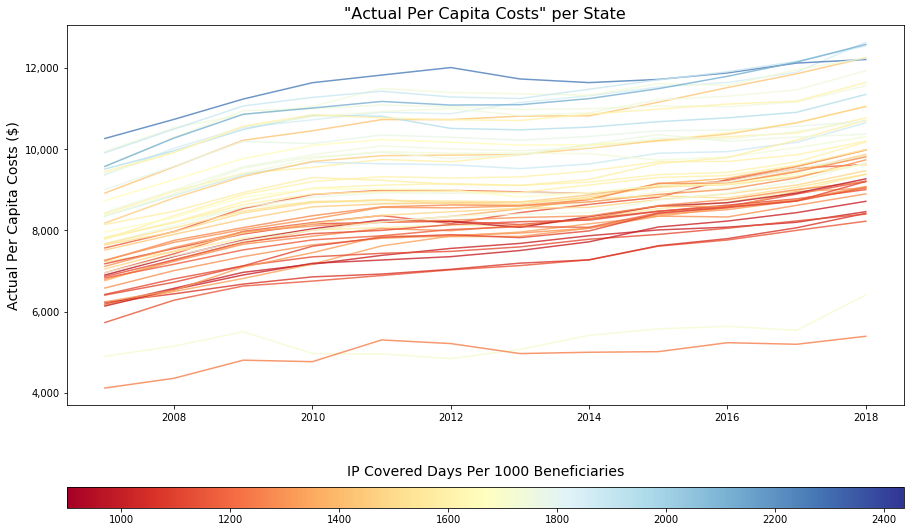

______________________________________________________________________________________________________________



/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


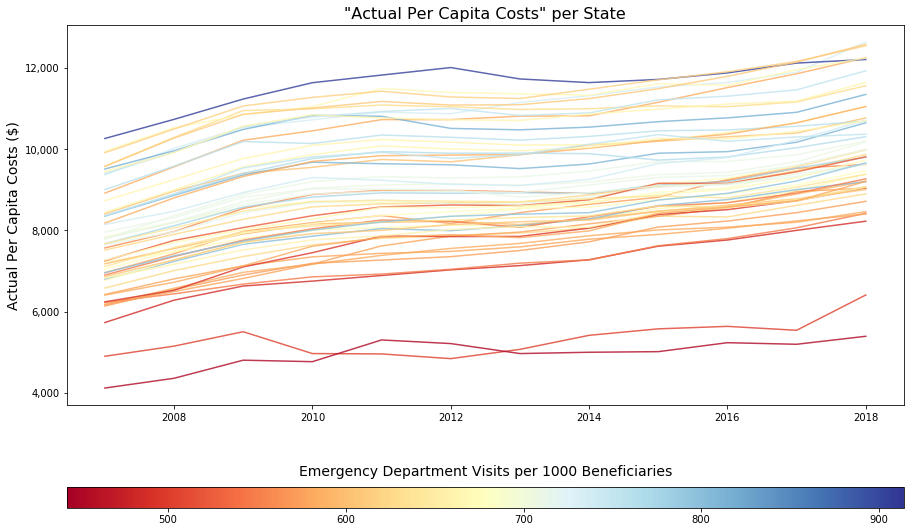

______________________________________________________________________________________________________________



/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


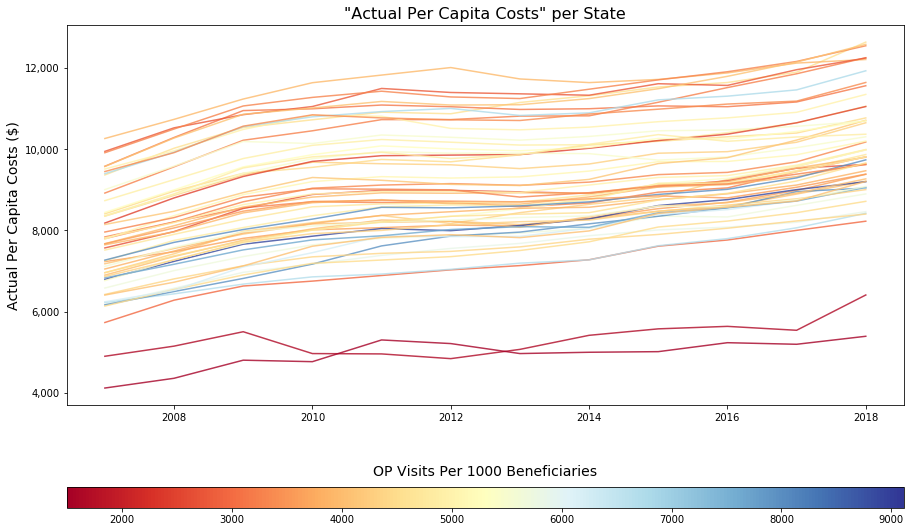

______________________________________________________________________________________________________________



/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


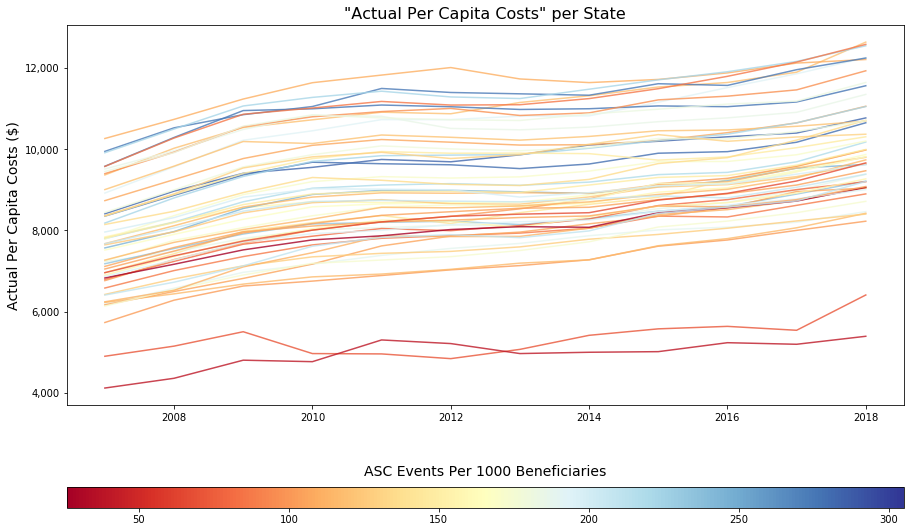

______________________________________________________________________________________________________________



/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


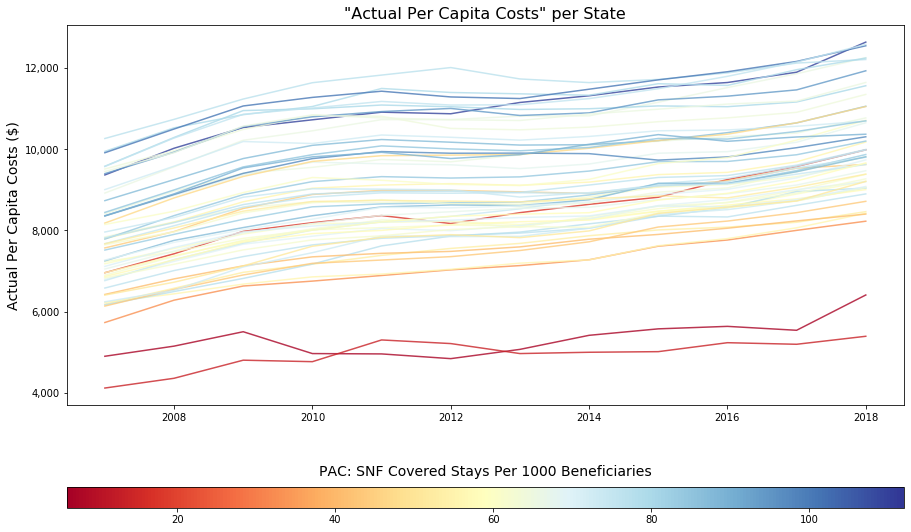

______________________________________________________________________________________________________________



/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


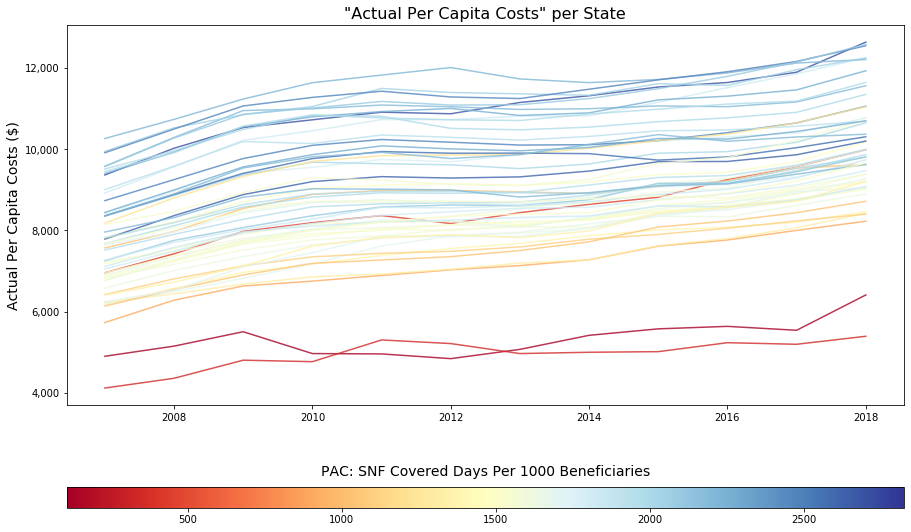

______________________________________________________________________________________________________________



/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


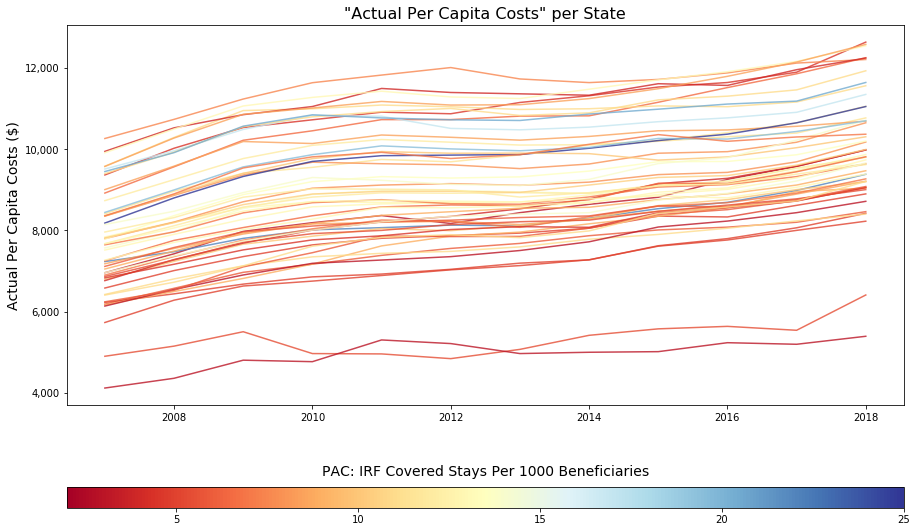

______________________________________________________________________________________________________________



/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


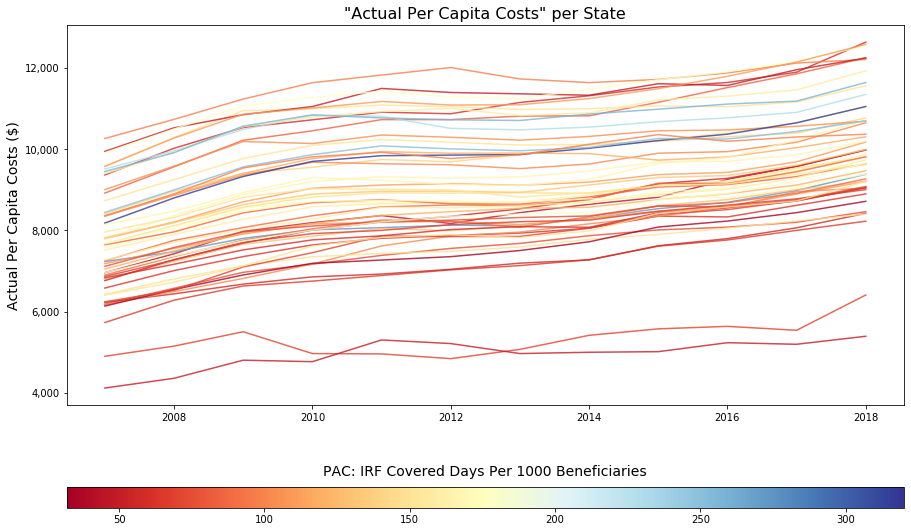

______________________________________________________________________________________________________________



/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


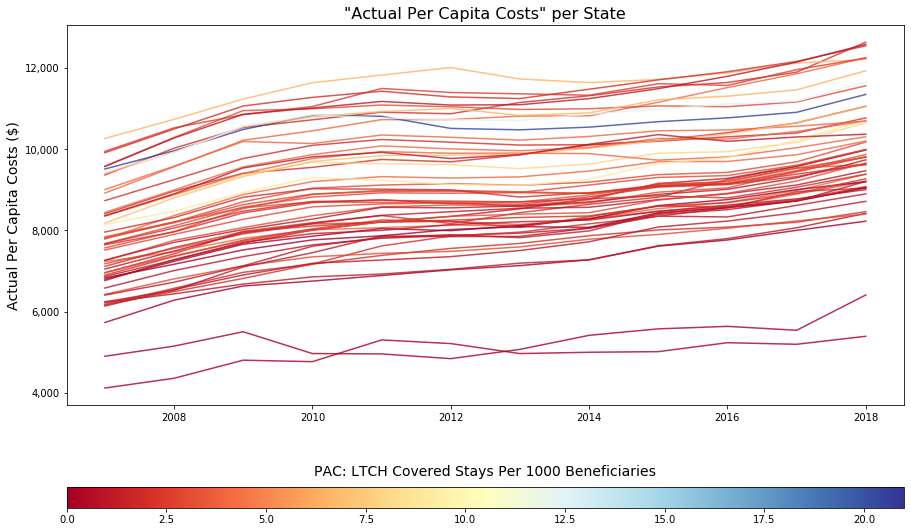

______________________________________________________________________________________________________________



/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


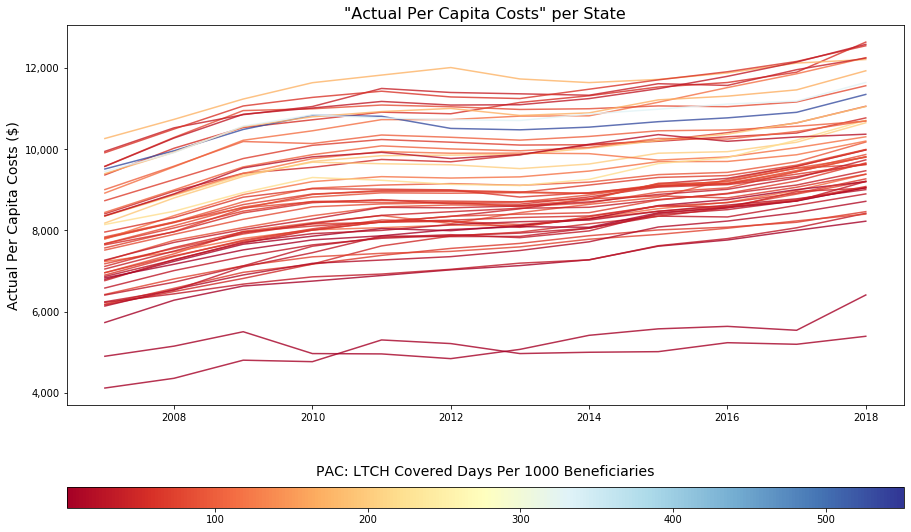

______________________________________________________________________________________________________________



/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


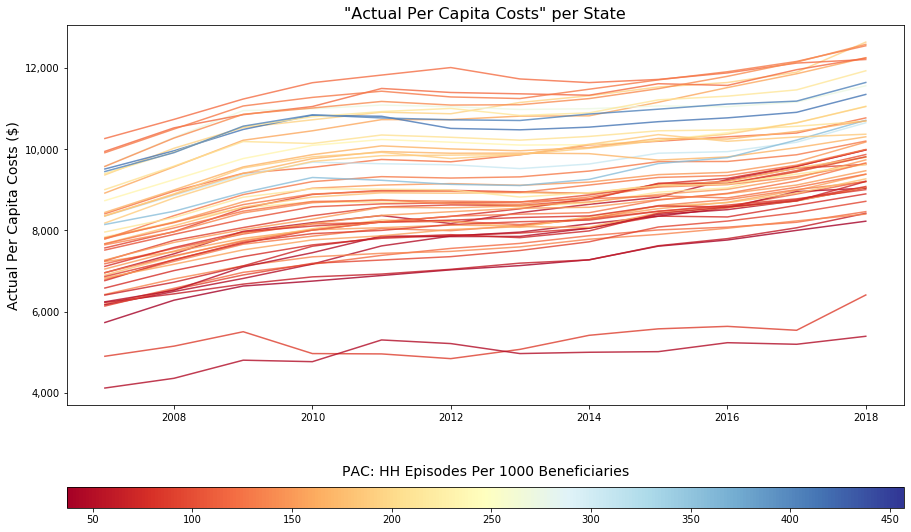

______________________________________________________________________________________________________________



/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


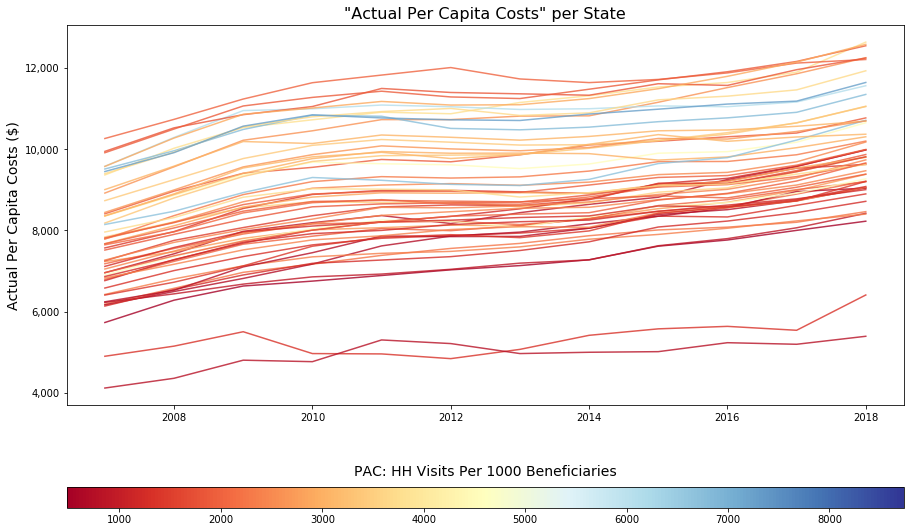

______________________________________________________________________________________________________________



/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


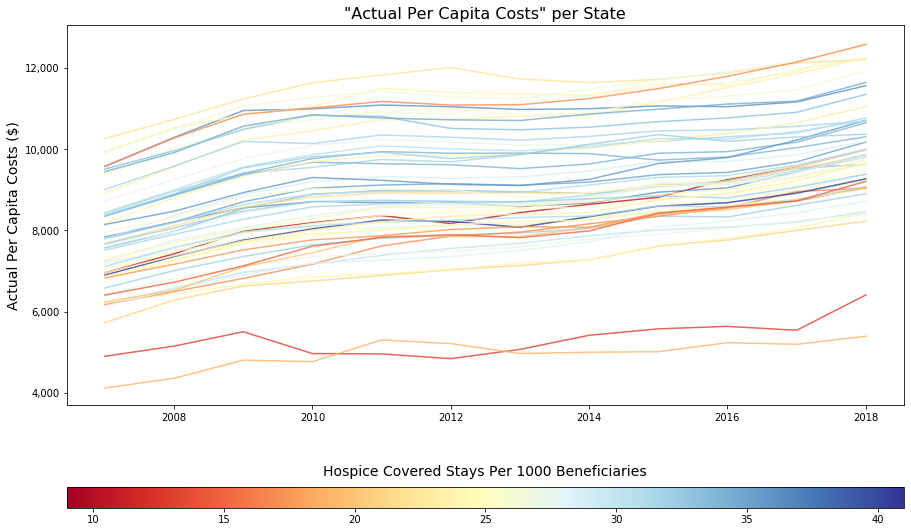

______________________________________________________________________________________________________________



/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


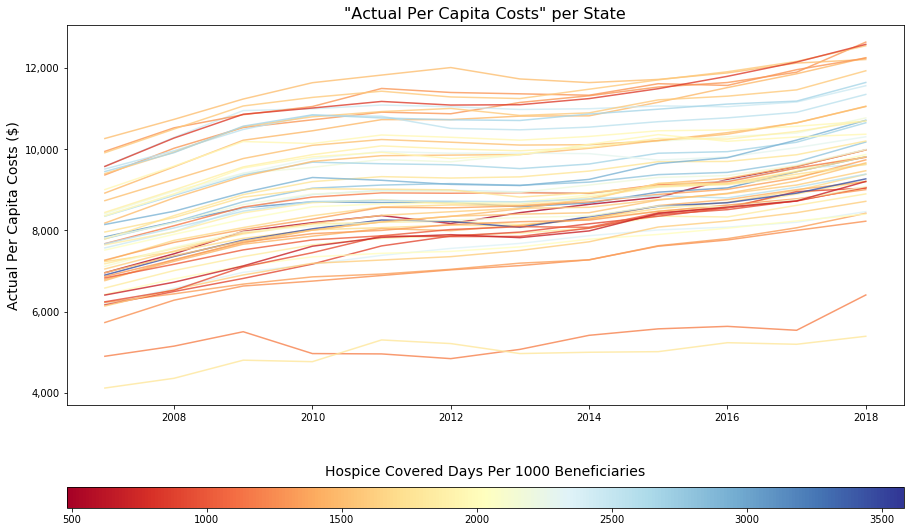

______________________________________________________________________________________________________________



/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


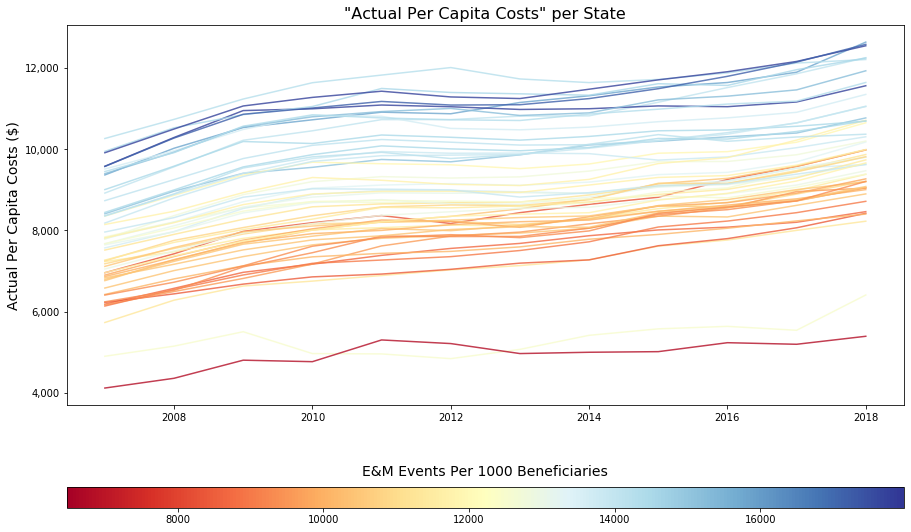

______________________________________________________________________________________________________________



/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


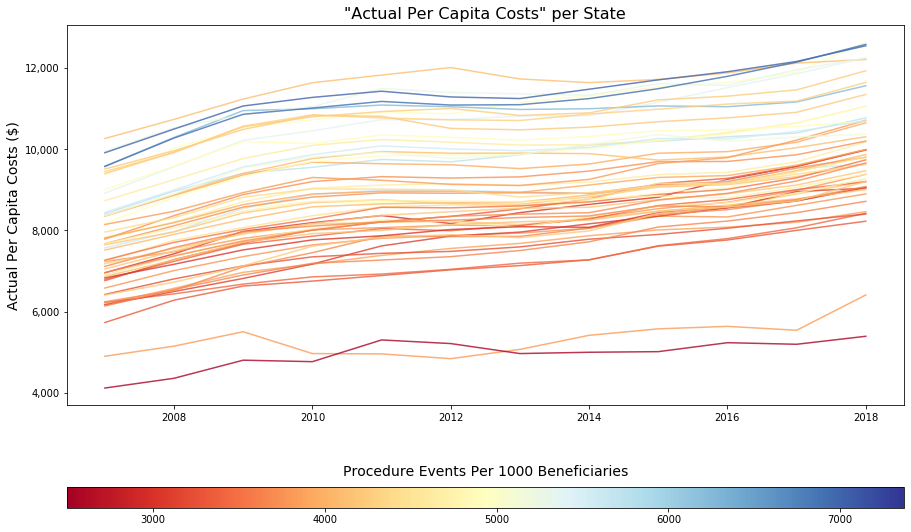

______________________________________________________________________________________________________________



/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


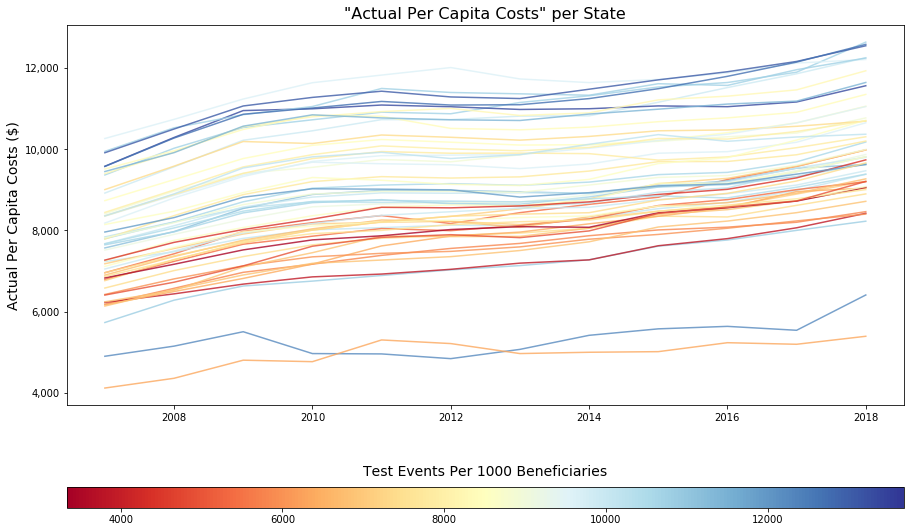

______________________________________________________________________________________________________________



/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


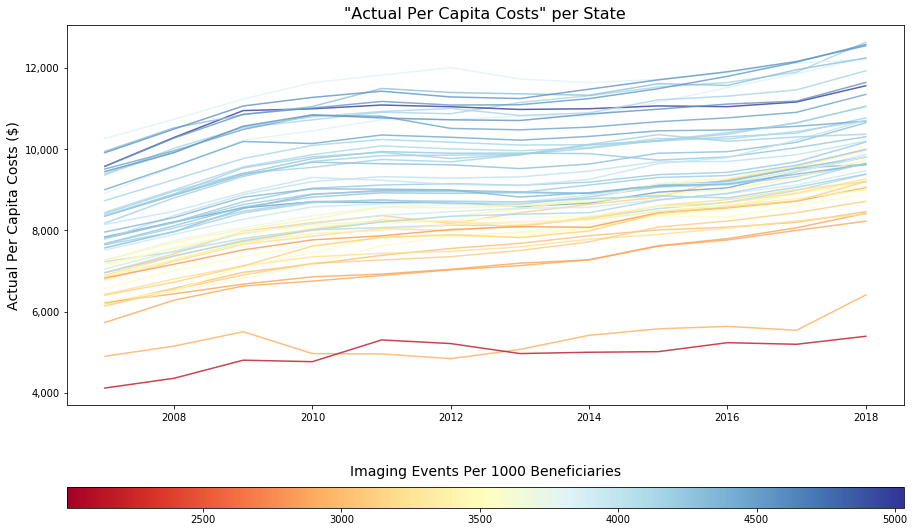

______________________________________________________________________________________________________________



/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


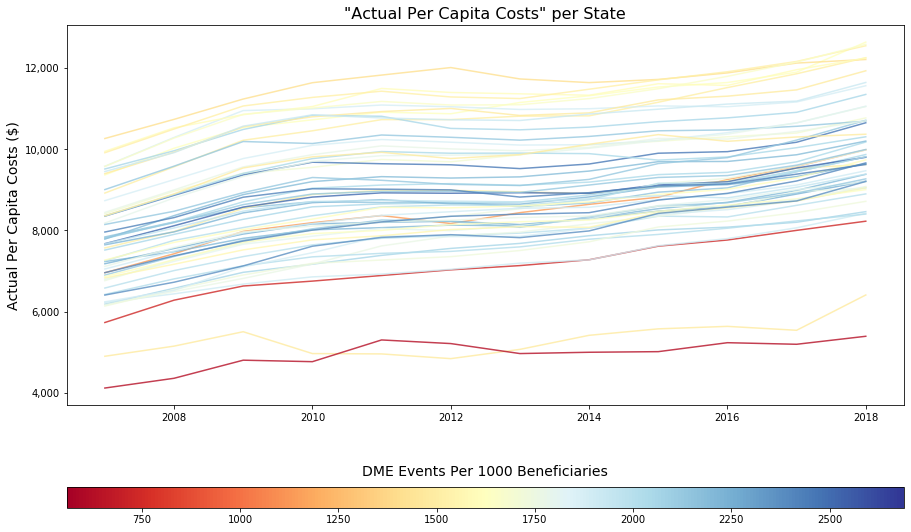

______________________________________________________________________________________________________________



/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


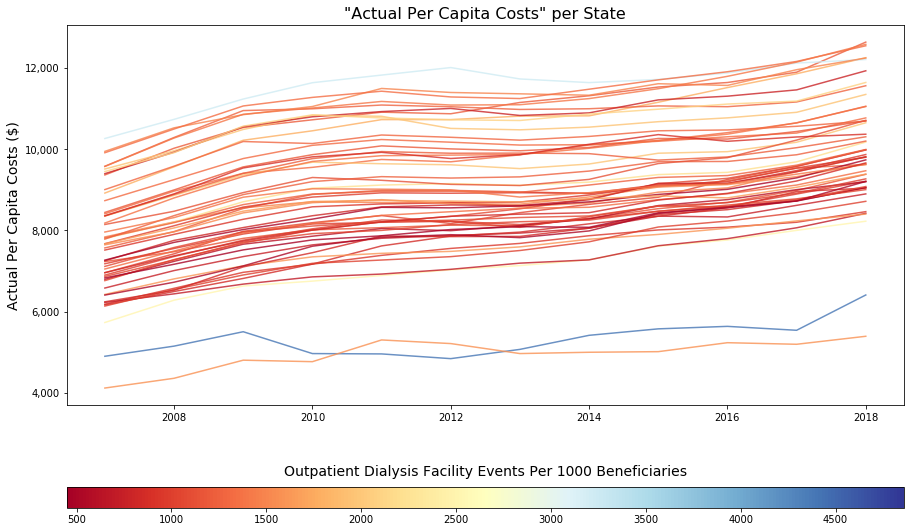

______________________________________________________________________________________________________________



/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


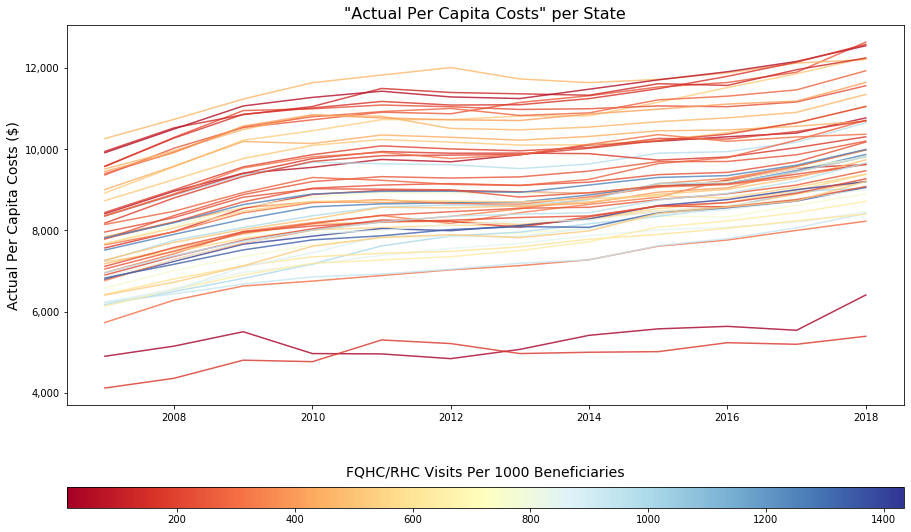

______________________________________________________________________________________________________________



/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/michaellink/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


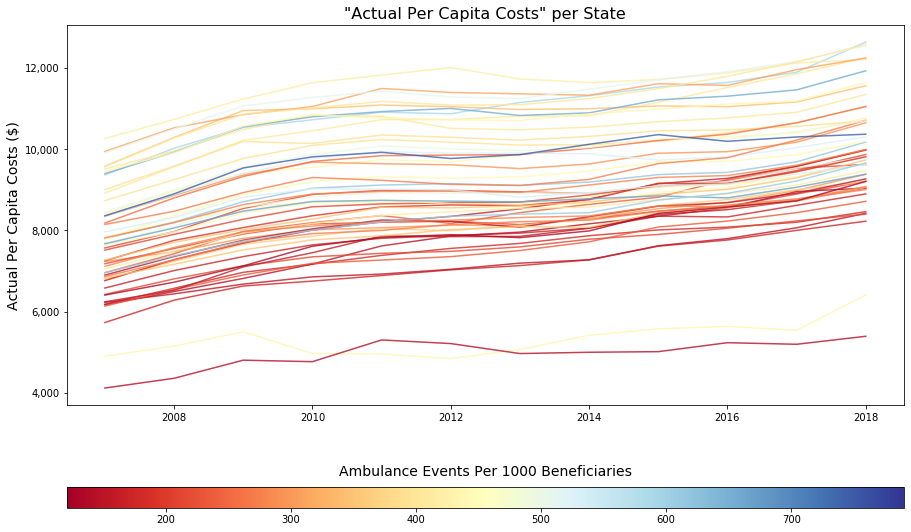

______________________________________________________________________________________________________________



In [14]:
lst_per_cap = [s for s in lst_col if "1000 Beneficiaries" in s]

for col in lst_per_cap:
    state_plotter(y_axis_string='Actual Per Capita Costs', color_string=col, df=df)
    print('_'*110 + '\n')